<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Useful-Functions" data-toc-modified-id="Useful-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Useful Functions</a></span></li><li><span><a href="#Load-and-Prepare-Player-Data" data-toc-modified-id="Load-and-Prepare-Player-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and Prepare Player Data</a></span></li><li><span><a href="#Create-Features-and-Labels-from-Training/Testing-Datasets" data-toc-modified-id="Create-Features-and-Labels-from-Training/Testing-Datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create Features and Labels from Training/Testing Datasets</a></span></li><li><span><a href="#Optimizing-and-Testing-Player-Classifier-Models" data-toc-modified-id="Optimizing-and-Testing-Player-Classifier-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimizing and Testing Player Classifier Models</a></span><ul class="toc-item"><li><span><a href="#Classification-with-Support-Vector-Machines" data-toc-modified-id="Classification-with-Support-Vector-Machines-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Classification with Support Vector Machines</a></span></li><li><span><a href="#Random-Forest-Classification" data-toc-modified-id="Random-Forest-Classification-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Random Forest Classification</a></span></li></ul></li><li><span><a href="#Predicting-Rookie-Player-Similarity" data-toc-modified-id="Predicting-Rookie-Player-Similarity-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predicting Rookie Player Similarity</a></span></li><li><span><a href="#Example-Player-Comparison-Plots" data-toc-modified-id="Example-Player-Comparison-Plots-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Example Player Comparison Plots</a></span></li></ul></div>

In [1]:
# Import modules and packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [22]:
# Set seaborn plot style
sns.set(context='talk')
sns.set_style("whitegrid")

# Useful Functions

In [58]:
# Function for adding annotating an XY scatter plot with player names
def AnnotatePlayerNames(ax, df, x, y, names, unique_only=False):
    last_x = 1e6
    for i,name in enumerate(names):
        if unique_only:
            df_temp = df[df.name == name].groupby(['name'], as_index=False).mean()
        else:
            df_temp = df[df.name == name]
        
        for idx, (_, row) in enumerate(df_temp.iterrows()):
            if i == 0:
                ax.scatter(row[x], row[y], marker='x', c='black', s=100)
            else:
                ax.scatter(row[x], row[y], marker='x', c='red', s=75)
            
            if row[x] > last_x:
                text_loc = 5
            else:
                text_loc = -len(list(name))*8
            
            if i == 0:
                ax.annotate(name, (row[x], row[y]), color='black', textcoords='offset points', xytext=(text_loc, 5), size=15)

            last_x = row[x]


# Load and Prepare Player Data

In [4]:
# Load comprehensive dataset of player stats
dfp = pd.read_csv('../CompleteNBAPlayerStats.csv')
dfp

,name,pos,team,year,GP,GS,height,weight,college,country,...,FG_FREQ_AB,FG_FREQ_01DRIB,FG_FREQ_GT1DRIB,FG_FREQ_CANDS,FG_FREQ_05FT,FG_FREQ_59FT,FG_FREQ_1014FT,FG_FREQ_1519FT,FG_FREQ_2024FT,FG_FREQ_GT24FT
0,Andre Miller,PG,TOT,2016,39.0,4.0,74.0,200.0,Utah,USA,...,0.000000,0.000000,0.000000,0.073514,0.514601,0.110272,0.183786,0.110272,0.036757,0.036757
1,Dirk Nowitzki,PF,DAL,2016,75.0,75.0,83.0,237.0,None,Germany,...,0.033812,0.000000,0.000000,0.540997,0.087912,0.054100,0.202874,0.290786,0.250211,0.311074
2,Dirk Nowitzki,PF,DAL,2017,54.0,54.0,83.0,237.0,None,Germany,...,0.023923,0.853270,0.000000,0.606061,0.071770,0.047847,0.151515,0.334928,0.271132,0.311005
3,Dirk Nowitzki,C,DAL,2018,77.0,77.0,83.0,237.0,None,Germany,...,0.030364,0.890688,0.000000,0.668016,0.050607,0.020243,0.172065,0.222672,0.222672,0.445344
4,Dirk Nowitzki,PF,DAL,2019,51.0,20.0,83.0,237.0,None,Germany,...,0.054299,0.923077,0.000000,0.733032,0.013575,0.054299,0.122172,0.190045,0.217195,0.542986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,Rui Hachimura,PF,WAS,2020,25.0,25.0,80.0,230.0,Gonzaga,Japan,...,0.057534,0.682192,0.304110,0.230137,0.468493,0.073973,0.123288,0.147945,0.098630,0.147945
1743,Sekou Doumbouya,SF,DET,2020,14.0,7.0,80.0,230.0,None,Guinea,...,0.196253,0.642284,0.000000,0.303301,0.410348,0.089206,0.035682,0.017841,0.124888,0.338983
1744,Terence Davis,SG,TOR,2020,39.0,1.0,76.0,201.0,None,USA,...,0.145653,0.710059,0.291306,0.473373,0.364133,0.036413,0.018207,0.018207,0.236686,0.564406
1745,Ty Jerome,PG,PHX,2020,10.0,0.0,77.0,195.0,Virginia,USA,...,0.020353,0.508820,0.488467,0.386703,0.183175,0.081411,0.244233,0.040706,0.101764,0.386703


In [5]:
# Establish a minimum number of games played and minutes per game (MPG)
min_num_games = 40
min_MPG = 10

# Apply cuts on GP/MPG/other parameters
df = dfp.copy()
#df = df[df.GP > min_num_games]
#df = df[df.MPG > min_MPG]

# Group and average rows with duplicate player-seasons
df = df[df.year < 2020].groupby(['name', 'year'], as_index=False).mean()

In [6]:
# Create separate dataframes for established players and rookies
df_vets = df[df["name"].isin(df["name"].value_counts()[df["name"].value_counts() == 4].index)]
df_train = df_vets[df_vets.year < 2019]
df_test = df_vets[df_vets.year == 2019]

df_rooks = df[df["name"].isin(df["name"].value_counts()[df["name"].value_counts() == 1].index)]
df_rooks = df_rooks[df_rooks.year == 2019]

print("Using a training dataset of size:", len(df_train))
print("Using a test dataset of size:", len(df_test))

Using a training dataset of size: 543
Using a test dataset of size: 181


# Create Features and Labels from Training/Testing Datasets

In [78]:
# Specify which dataframe columns to use as model features
feature_list = ['height', 'weight', 'FG_FREQ_05FT', 'FG_FREQ_59FT', 'FG_FREQ_1014FT', 
                'FG_FREQ_1519FT', 'FG_FREQ_2024FT', 'FG_FREQ_GT24FT', 'FG_FREQ_CANDS', 
                'FTR', 'ASTR', 'TOR', 'ORR', 'DRR', 'BLK_PH', 'STL_PH', 'DFGP_PG']

# Display the dataframe with selected features
#df[['name'] + feature_list].to_clipboard(index=False,header=False)
pd.set_option('display.max_columns', 13)
df[['name'] + feature_list]

,name,height,weight,FG_FREQ_05FT,FG_FREQ_59FT,FG_FREQ_1014FT,...,TOR,ORR,DRR,BLK_PH,STL_PH,DFGP_PG
0,Aaron Brooks,72.0,161.0,0.294214,0.132396,0.088264,...,10.8,2.0,7.5,0.4,1.3,0.389
1,Aaron Brooks,72.0,161.0,0.258714,0.086238,0.107797,...,12.8,2.3,6.3,0.5,1.4,0.455
2,Aaron Gordon,81.0,220.0,0.484160,0.080693,0.067244,...,7.7,9.0,21.3,1.4,1.5,0.442
3,Aaron Gordon,81.0,220.0,0.387374,0.073786,0.073786,...,7.4,5.3,14.1,0.9,1.4,0.437
4,Aaron Gordon,81.0,220.0,0.328939,0.060417,0.080556,...,8.9,5.0,21.5,1.1,1.5,0.432
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,Zaza Pachulia,83.0,240.0,0.616883,0.113636,0.097403,...,14.2,13.7,25.7,0.6,1.6,0.492
1391,Zaza Pachulia,83.0,240.0,0.754429,0.068584,0.068584,...,15.0,12.9,22.0,1.2,2.2,0.545
1392,Zaza Pachulia,83.0,240.0,0.703430,0.104212,0.078159,...,14.8,11.0,25.0,0.8,1.8,0.509
1393,Zaza Pachulia,83.0,240.0,0.635855,0.105976,0.070651,...,14.4,11.9,21.5,0.9,1.7,0.462


In [15]:
# Create input features and target labels (player names) for test data
test_labels = df_test[["name"]]
test_features = df_test[feature_list]

# Create matching training dataset using only veterans who are still in the NBA 
# (and thus have available training data)
train_labels = df_train[["name"]]
train_features = df_train[feature_list]

# Scale features which will be used in model fitting
# (both training and testing datasets)
scale = StandardScaler().fit(train_features)
train_features = scale.transform(train_features)
test_features = scale.transform(test_features)

# Optimizing and Testing Player Classifier Models

## Classification with Support Vector Machines

In [117]:
# Perform a comprehensive grid search to optimize parameters for SVM classification
gammas = [0.0001, 0.001, 0.01, 0.1, 1]
Cs = [1, 10, 100, 1000, 10000]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=3)
grid_search.fit(train_features, train_labels.values.ravel())
grid_search.best_params_
print('Optimized hyperparameters:', grid_search.best_params_)

Optimized hyperparameters: {'C': 100, 'gamma': 0.01}


In [118]:
# Instantiate classifier model using optimized parameters 
# and fit the model to the training dataset
clf = svm.SVC(gamma=grid_search.best_params_['gamma'], C=grid_search.best_params_['C'])
clf.fit(train_features, train_labels.values.ravel())

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [119]:
# Implement the model on test data (veteran stats from the last full season) 
# and classify/predict which player is which based on those recent stats
y_pred = clf.predict(test_features)

# Calculate rough accuracy of the test dataset by matching predictions with test labels
print("Classified veteran players with an accuracy of", np.sum(test_labels.name.values==y_pred)*100./(len(y_pred)*1.), "%")


Classified veteran players with an accuracy of 74.58563535911603 %


## Random Forest Classification

In [16]:
# Perform a comprehensive grid search to optimize parameters for Random Forest classification
n_estimators = [100, 500, 1000, 2000, 5000]
max_depth = [5, 15, 30]
min_samples_split = [2, 10, 100]
min_samples_leaf = [1, 5, 10]

param_grid = {'n_estimators': n_estimators, 'max_depth' : max_depth, 
              'min_samples_split' : min_samples_split, 'min_samples_leaf' : min_samples_leaf}
grid_search = GridSearchCV(RandomForestClassifier(random_state = 1), param_grid, cv=3)
grid_search.fit(train_features, train_labels.values.ravel())
grid_search.best_params_
print('Optimized hyperparameters:', grid_search.best_params_)

rfc = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'], 
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'] )

Optimized hyperparameters: {'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 2000}


In [17]:
# Fit the training dataset
#rfc = RandomForestClassifier(n_estimators=1000, max_depth=30, min_samples_split=2, min_samples_leaf=5)
rfc.fit(train_features, train_labels.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
# Run the classifier model on the test data
y_pred = rfc.predict(test_features)
print("Classified veteran players with an accuracy of", np.sum(test_labels.name.values==y_pred)*100./(len(y_pred)*1.), "%")


Classified veteran players with an accuracy of 92.81767955801105 %


In [1]:
# Show the veteran players and their predicted test match 
# (for Random Forest classifier)
#for i,pred in enumerate(y_pred):
#    print("Predicted that Player", test_labels.name.values[i], "is Player", pred)

# Predicting Rookie Player Similarity

In [19]:
# Format rookie dataset for input into the classifier and 
# attempt to classify rookies by their most similar veteran counterpart
pred_labels = df_rooks[["name"]]
pred_features = df_rooks[feature_list]

pred_features = scale.transform(pred_features)
rook_pred = rfc.predict(pred_features)

for i,pred in enumerate(rook_pred):
    print("Predicted that Rookie", pred_labels.name.values[i], "is similar to Player:", pred)
    

Predicted that Rookie Aaron Holiday is similar to Player: Isaiah Canaan
Predicted that Rookie Alfonzo McKinnie is similar to Player: JaMychal Green
Predicted that Rookie Boban Marjanovic is similar to Player: Jusuf Nurkic
Predicted that Rookie Bonzie Colson is similar to Player: PJ Tucker
Predicted that Rookie Brandon Sampson is similar to Player: Jordan Clarkson
Predicted that Rookie Bruce Brown is similar to Player: Tyreke Evans
Predicted that Rookie Cameron Reynolds is similar to Player: Wesley Matthews
Predicted that Rookie Chandler Hutchison is similar to Player: Justise Winslow
Predicted that Rookie Cheick Diallo is similar to Player: Taj Gibson
Predicted that Rookie Christian Wood is similar to Player: Karl-Anthony Towns
Predicted that Rookie DJ Wilson is similar to Player: Markieff Morris
Predicted that Rookie Daniel Hamilton is similar to Player: D'Angelo Russell
Predicted that Rookie Daryl Macon is similar to Player: Kemba Walker
Predicted that Rookie De'Aaron Fox is similar 

# Example Player Comparison Plots

In [20]:
# Combine veteran and rookie datasets for ease of comparison plotting
frames = [df_vets, df_rooks]
df_comb = pd.concat(frames)

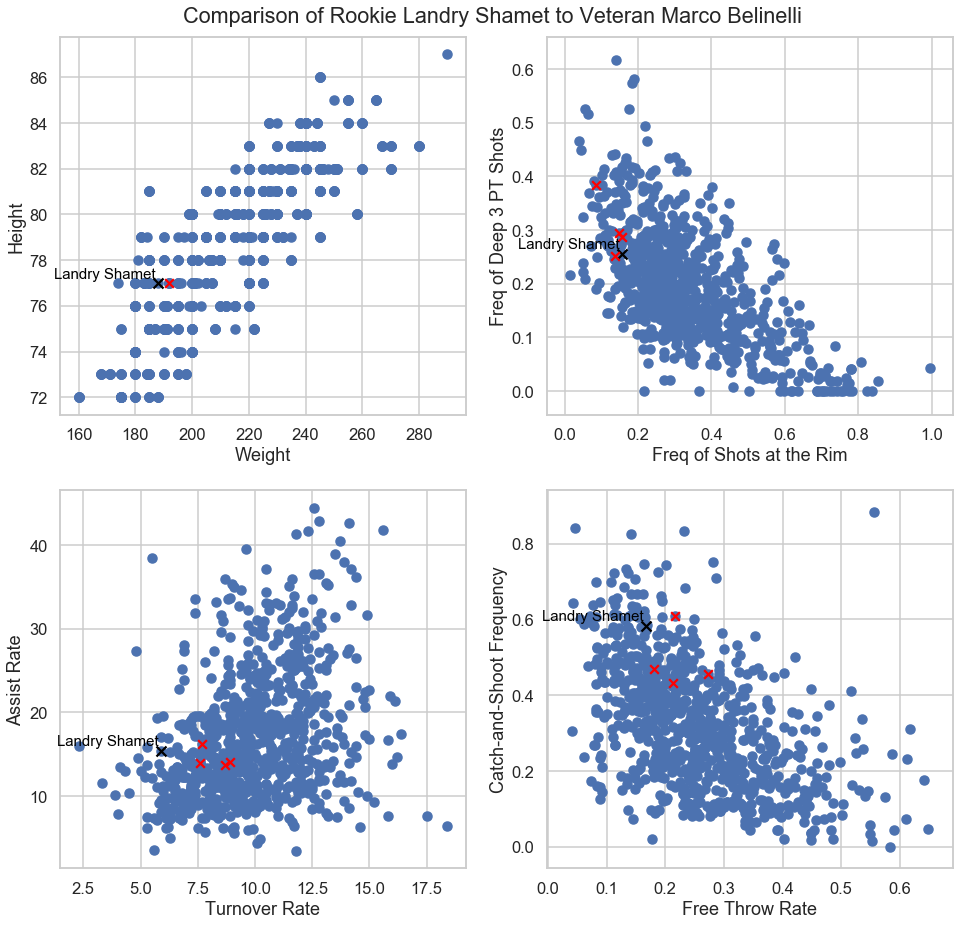

In [63]:
# Plot a grid of key comparison plots for rookie/veteran example
fig, ax = plt.subplots(2, 2, figsize=(16, 14))

plt.suptitle('Comparison of Rookie Landry Shamet to Veteran Marco Belinelli')
#fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.axes(ax[0,0])
plt.xlabel("Weight")
plt.ylabel("Height")
plt.scatter(df_comb.weight, df_comb.height)
AnnotatePlayerNames(ax[0,0], df_comb, 'weight', 'height', ['Landry Shamet', 'Marco Belinelli'], True)

plt.axes(ax[0,1])
plt.xlabel("Freq of Shots at the Rim")
plt.ylabel("Freq of Deep 3 PT Shots")
plt.scatter(df_comb['FG_FREQ_05FT'], df_comb['FG_FREQ_2024FT'])
AnnotatePlayerNames(ax[0,1], df_comb, 'FG_FREQ_05FT', 'FG_FREQ_2024FT', ['Landry Shamet', 'Marco Belinelli'])

plt.axes(ax[1,0])
plt.xlabel("Turnover Rate")
plt.ylabel("Assist Rate")
plt.scatter(df_comb[df_comb.TOR<30].TOR, df_comb[df_comb.TOR<30].ASTR)
AnnotatePlayerNames(ax[1,0], df_comb[df_comb.TOR<30], 'TOR', 'ASTR', ['Landry Shamet', 'Marco Belinelli'])

plt.axes(ax[1,1])
plt.xlabel("Free Throw Rate")
plt.ylabel("Catch-and-Shoot Frequency")
plt.scatter(df_comb.FTR.values, df_comb.FG_FREQ_CANDS.values)
AnnotatePlayerNames(ax[1,1], df_comb, 'FTR', 'FG_FREQ_CANDS', ['Landry Shamet', 'Marco Belinelli'])


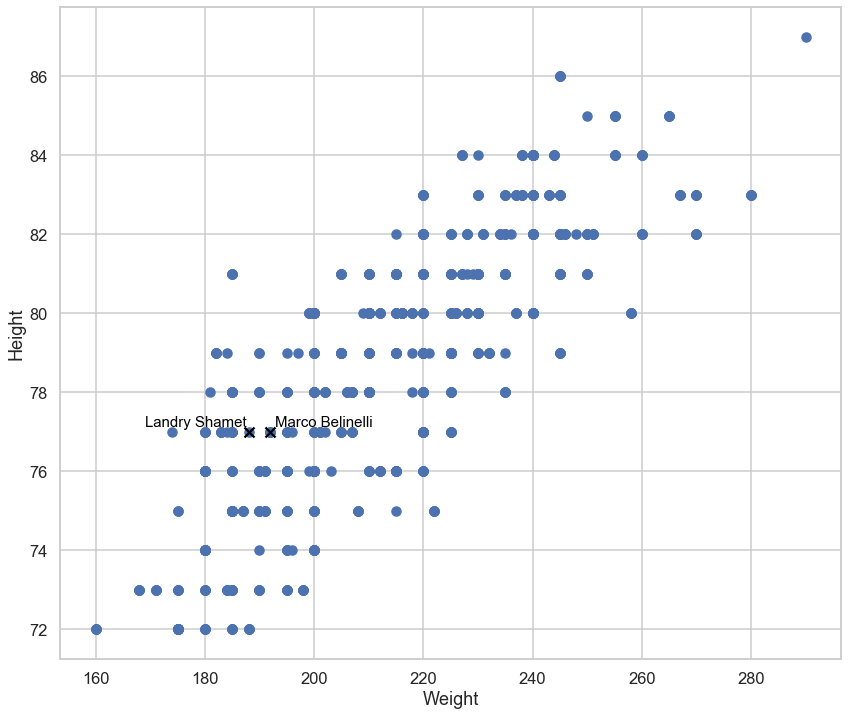

In [25]:
# Compare physical attributes (weight, height) of the players 
fig, ax = plt.subplots(figsize=(14, 12))
plt.xlabel("Weight")
plt.ylabel("Height")
plt.scatter(df_comb.weight, df_comb.height)
AnnotatePlayerNames(df_comb, 'weight', 'height', ['Landry Shamet', 'Marco Belinelli'], True)
        

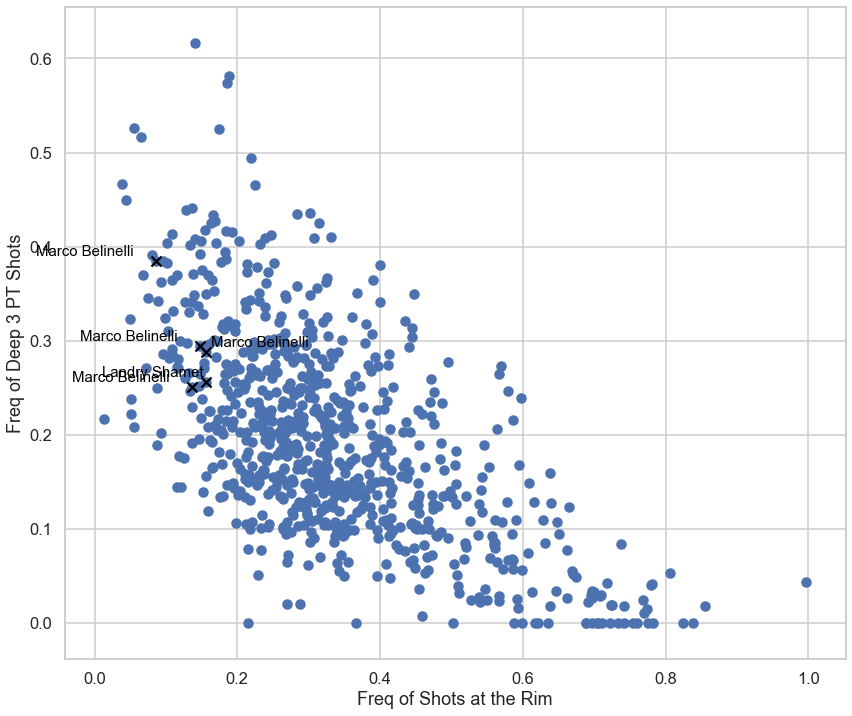

In [26]:
# Compare ratio of shots taken at the rim (dunks, layups)
# and ratio of 3-pointers taken above the break
fig, ax = plt.subplots(figsize=(14, 12))
plt.xlabel("Freq of Shots at the Rim")
plt.ylabel("Freq of Deep 3 PT Shots")
plt.scatter(df_comb['FG_FREQ_05FT'], df_comb['FG_FREQ_2024FT'])
AnnotatePlayerNames(df_comb, 'FG_FREQ_05FT', 'FG_FREQ_2024FT', ['Landry Shamet', 'Marco Belinelli'])
        

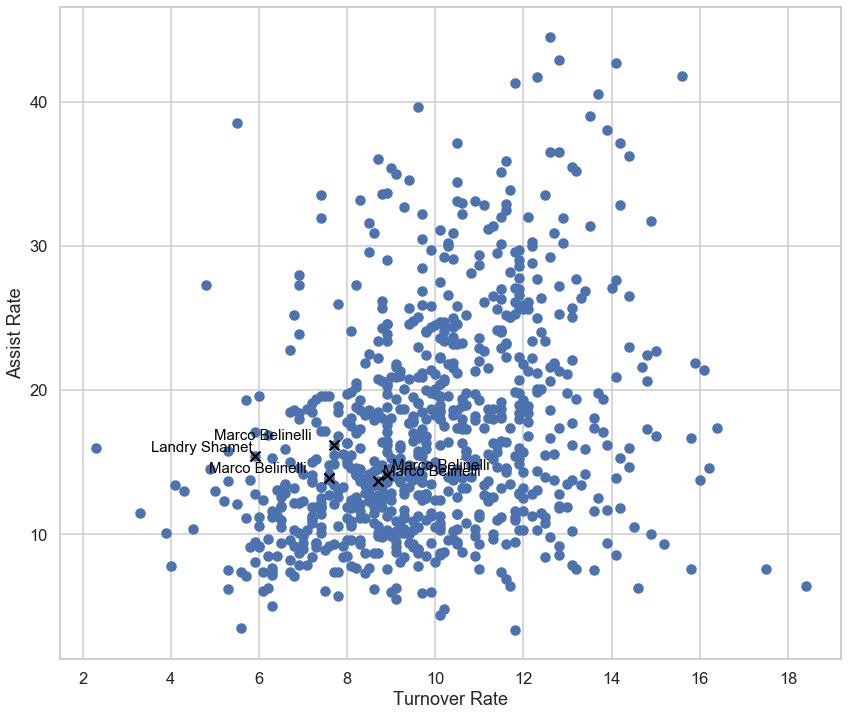

In [27]:
# Compare how often player possessions result in an assist or turnover
fig, ax = plt.subplots(figsize=(14, 12))
plt.xlabel("Turnover Rate")
plt.ylabel("Assist Rate")
plt.scatter(df_comb[df_comb.TOR<30].TOR, df_comb[df_comb.TOR<30].ASTR)
AnnotatePlayerNames(df_comb[df_comb.TOR<30], 'TOR', 'ASTR', ['Landry Shamet', 'Marco Belinelli'])


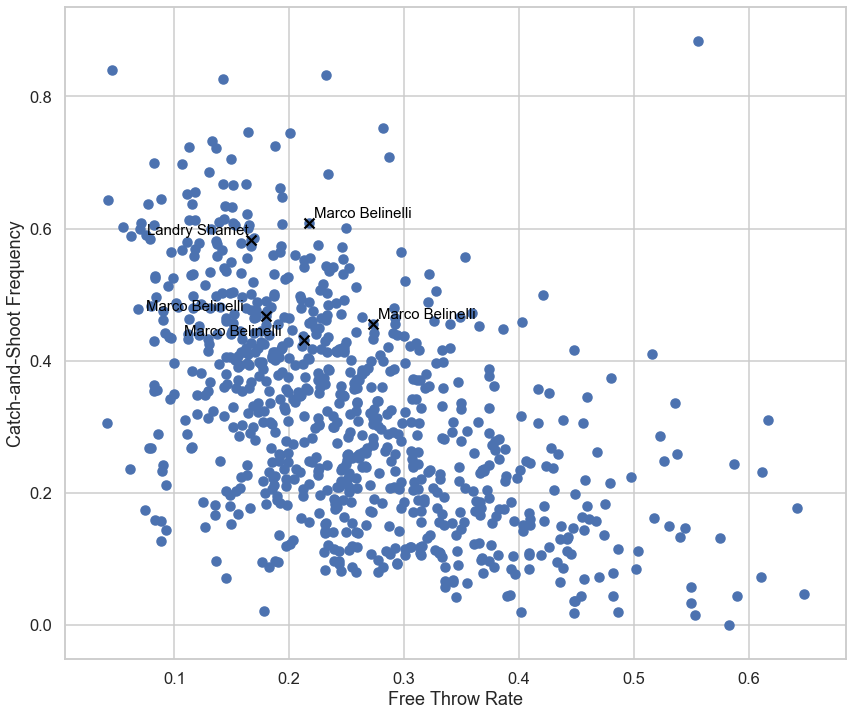

In [28]:
# Compare a defensive metric (opponent field goal %)
# with the player's catch-and-shoot frequency
fig, ax = plt.subplots(figsize=(14, 12))
plt.xlabel("Free Throw Rate")
plt.ylabel("Catch-and-Shoot Frequency")
plt.scatter(df_comb.FTR.values, df_comb.FG_FREQ_CANDS.values)
AnnotatePlayerNames(df_comb, 'FTR', 'FG_FREQ_CANDS', ['Landry Shamet', 'Marco Belinelli'])
        

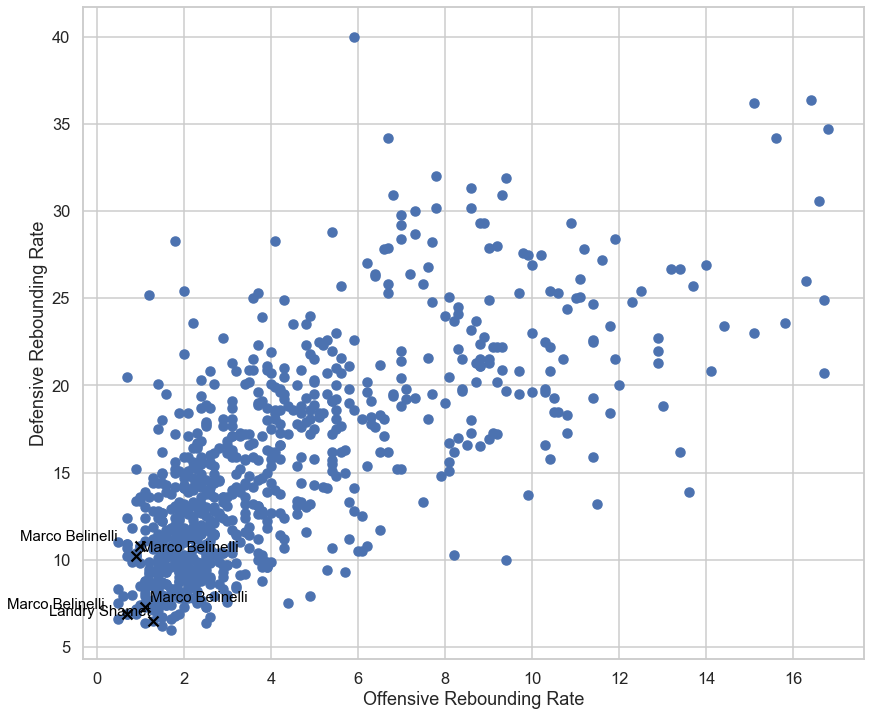

In [29]:
# Compare offensive and defensive rebounding rates
fig, ax = plt.subplots(figsize=(14, 12))
plt.xlabel("Offensive Rebounding Rate")
plt.ylabel("Defensive Rebounding Rate")
plt.scatter(df_comb[df_comb.ORR>0].ORR.values, df_comb[df_comb.ORR>0].DRR.values)
AnnotatePlayerNames(df_comb[df_comb.ORR>0], 'ORR', 'DRR', ['Landry Shamet', 'Marco Belinelli'])
